In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

Archive:  facemo.zip
   creating: facemo/images/
   creating: facemo/images/train/
   creating: facemo/images/train/angry/
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (2) - Copy.jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (2).jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (3) - Copy.jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (3).jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (4).jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (5).jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy (6).jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035 - Copy.jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143035.jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143037 - Copy (2).jpg  
  inflating: facemo/images/train/angry/IMG_20230331_143037 - Copy (3).jpg  
  inflating: facemo/images/train/angry/IMG

In [2]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [3]:
folder_path = "/content/facemo/images/" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [4]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = 75
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 2827/2827 [00:01<00:00, 1778.46it/s]


In [5]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [6]:
batch_size = 32
picture_size = (SIZE,SIZE)
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(folder_path + 'train',
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path + 'validation',
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 2827 images belonging to 5 classes.
Found 797 images belonging to 5 classes.


In [15]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


no_of_classes = 5

with stg.scope():
    base_model = tf.keras.applications.InceptionV3(weights="imagenet",
                                            input_shape=(SIZE, SIZE, 3),
                                            include_top=False,)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                      

In [16]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)

callbacks = [early_stopping, lr_scheduler]


In [17]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=32,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size,
                    callbacks=callbacks)

Epoch 1/32
88/88 [==============================] - 18s 129ms/step - loss: 1.1129 - accuracy: 0.5750 - val_loss: 0.8884 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 2/32
88/88 [==============================] - 9s 101ms/step - loss: 0.7182 - accuracy: 0.7410 - val_loss: 0.7257 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 3/32
88/88 [==============================] - 9s 100ms/step - loss: 0.5859 - accuracy: 0.7814 - val_loss: 0.5698 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 4/32
88/88 [==============================] - 7s 81ms/step - loss: 0.4977 - accuracy: 0.8190 - val_loss: 0.5989 - val_accuracy: 0.7474 - lr: 0.0010
Epoch 5/32
88/88 [==============================] - 8s 95ms/step - loss: 0.4402 - accuracy: 0.8343 - val_loss: 0.5205 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 6/32
88/88 [==============================] - 8s 95ms/step - loss: 0.4043 - accuracy: 0.8619 - val_loss: 0.4395 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 7/32
88/88 [==============================] - 9s 101ms/step - loss

In [18]:
model.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

last_epoch = 20
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=40, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 21/40
89/89 [==============================] - 63s 167ms/step - loss: 1.1949 - accuracy: 0.5122 - val_loss: 11.1322 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 22/40
89/89 [==============================] - 11s 119ms/step - loss: 0.5810 - accuracy: 0.7846 - val_loss: 12.1362 - val_accuracy: 0.2597 - lr: 0.0010
Epoch 23/40
89/89 [==============================] - ETA: 0s - loss: 0.7800 - accuracy: 0.7347
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
89/89 [==============================] - 11s 120ms/step - loss: 0.7800 - accuracy: 0.7347 - val_loss: 2643.9534 - val_accuracy: 0.2321 - lr: 0.0010
Epoch 24/40
89/89 [==============================] - 11s 127ms/step - loss: 0.3834 - accuracy: 0.8787 - val_loss: 0.7546 - val_accuracy: 0.7290 - lr: 1.0000e-04
Epoch 25/40
89/89 [==============================] - 11s 125ms/step - loss: 0.2559 - accuracy: 0.9215 - val_loss: 0.2784 - val_accuracy: 0.9498 - lr: 1.0000e-04
Epoch 26/40
89/89 [======================

In [19]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 1s 24ms/step - loss: 0.1908 - accuracy: 0.9636
Test accuracy: 0.9636135697364807


0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 2s 2s/step


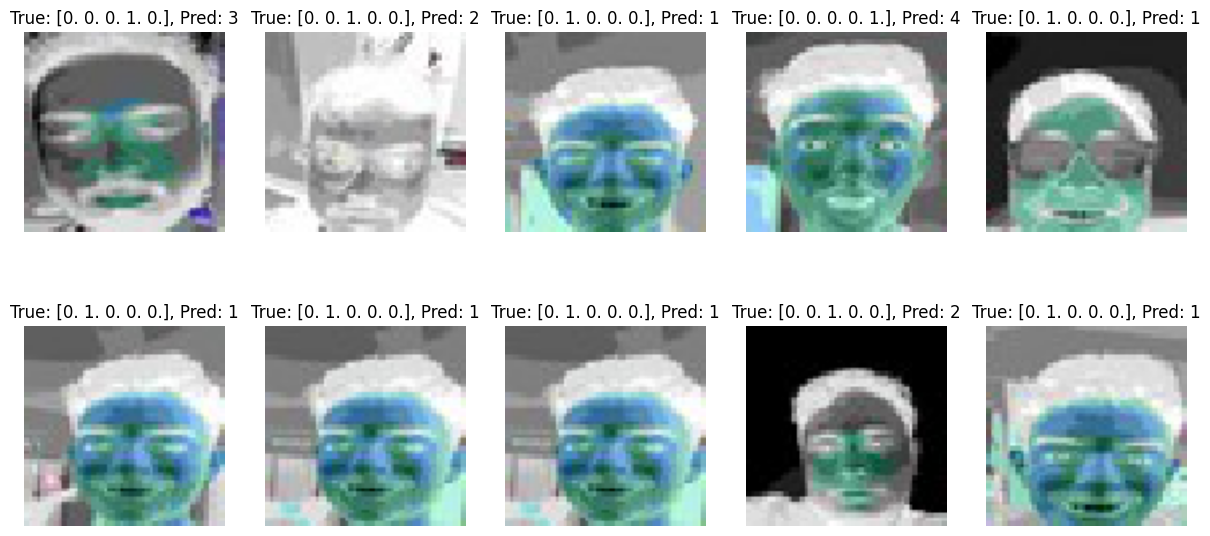

In [20]:
import numpy as np
import matplotlib.pyplot as plt
e = ['Angry','Happy','Neutral','Sad','Surprise']
for i in range(len(e)):
    print(i,"=",e[i])
# Get a batch of 10 random images from the test set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()

